In [1]:
# module import
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 실제 데이터(가우지안 분포) 생성
real_data = np.random.normal(size=1000).astype(np.float32)
real_data = real_data.reshape(real_data.shape[0], 1) # (1000, 1)
real_data.shape

(1000, 1)

In [3]:
# 미니배치용 데이터 셋
real_data_batch = tf.data.Dataset.from_tensor_slices(real_data)\
                    .shuffle(buffer_size=real_data.shape[0])\
                    .batch(batch_size=300)
real_data_batch

<BatchDataset shapes: (None, 1), types: tf.float32>

In [4]:
# KL Divergence 계산 함수 정의
def calc_KL(P, Q):
    hist_P, bins_P = np.histogram(P)
    hist_Q, bins_Q = np.histogram(Q)

    pdf_P = hist_P / (np.sum(hist_P) + 1e-8)
    pdf_Q = hist_Q / (np.sum(hist_Q) + 1e-8)

    kld_PQ = np.sum(pdf_P * (np.log(pdf_P + 1e-8) - np.log(pdf_Q + 1e-8)))

    return pdf_P, pdf_Q, kld_PQ

In [5]:
# log 클리핑
def clip_log(x):
    return tf.math.log(x + 1e-8)

In [6]:
# Discriminator 네트워크
d_input = real_data.shape[1]
d_hidden = 8
d_output = 1 # 주의

d_Wh = tf.Variable(tf.random.normal(shape=[d_input, d_hidden]), name='D_hidden_weight')
d_Bh = tf.Variable(tf.random.normal(shape=[d_hidden]), name='D_hidden_bias')
d_Wo = tf.Variable(tf.random.normal(shape=[d_hidden, d_output]), name='D_output_weight')
d_Bo = tf.Variable(tf.random.normal(shape=[d_output]), name='D_output_bias')

theta_D = [d_Wh, d_Bh, d_Wo, d_Bo] # 파라미터 한 번에 묶기

In [7]:
# Generator 네트워크
g_input = 8
g_hidden = 4
g_output = d_input # 주의

g_Wh = tf.Variable(tf.random.normal(shape=[g_input, g_hidden]), name='G_hidden_weight')
g_Bh = tf.Variable(tf.random.normal(shape=[g_hidden]), name='G_hidden_bias')
g_Wo = tf.Variable(tf.random.normal(shape=[g_hidden, g_output]), name='G_output_weight')
g_Bo = tf.Variable(tf.random.normal(shape=[g_output]), name='G_output_bias')

theta_G = [g_Wh, g_Bh, g_Wo, g_Bo] # 파라미터 한 번에 묶기

In [8]:
# Discriminator: 들어온 데이터가 맞는지 아닌지 출력
def Discriminator(data):
    d_Hidden = tf.matmul(data, d_Wh) + d_Bh
    d_Hidden = tf.nn.relu(d_Hidden) # activation
    d_Out = tf.matmul(d_Hidden, d_Wo) + d_Bo 
    d_Out = tf.nn.sigmoid(d_Out)
    return d_Out

In [9]:
# Generator: 들어온 데이터 넣어 줌.
def Generator(data):
    g_Hidden = tf.matmul(data, g_Wh) + g_Bh
    g_Hidden = tf.nn.relu(g_Hidden)
    g_Out = tf.matmul(g_Hidden, g_Wo) + g_Bo
    return g_Out # activation 없음.

In [10]:
# 가짜 데이터 생성: (m, n) 크기의 랜덤한 정규분포 = 원래 real과 같다는 보장 없음.
def makeZ(m, n=g_input):
    z = np.random.normal(-1.0, 1.0, size=[m, n]).astype(np.float32)
    return z

In [11]:
# Discriminator Loss
def loss_Discriminator(x, z):
    Dx = Discriminator(x) # discriminator가 판별한 진짜 x
    Gz = Generator(z) # generator가 생성한 가짜 데이터
    DGz = Discriminator(Gz) # discriminator가 판별한 가짜 데이터 z

    loss = tf.reduce_mean(clip_log(Dx) + clip_log(1-DGz))
    
    return -loss # minimize로 바꿔 줌.

In [12]:
# Generator Loss
def loss_Generator(z):
    Gz = Generator(z)
    DGz = Discriminator(Gz)

    loss = tf.reduce_mean(clip_log(1-DGz))
    return loss

In [13]:
# 옵티마이저: 0.005로 했을 때 난리났다.
opt = Adam(learning_rate=0.0005)

# 학습 시 loss, KLD 기록
loss_D_history = []
loss_G_history = []
KLdivergence_history=[]

# 학습 파라미터
EPOCHS = int(input('학습 횟수 설정: '))

for epoch in range(EPOCHS): # 1번 학습할 때마다

    for X_batch in real_data_batch: # 미니배치 단위로 밀어 넣음.
        Z_batch = makeZ(m=X_batch.shape[0], n=g_input) # 가짜 데이터

        opt.minimize(lambda: loss_Discriminator(X_batch, Z_batch), var_list=theta_D) # discriminator먼저 학습한 뒤,
        opt.minimize(lambda: loss_Generator(Z_batch), var_list=theta_G) # generator 학습.

    if epoch % 10 == 0: # 10회 학습 주기별로 기록
        loss_D_history.append(loss_Discriminator(X_batch, Z_batch))
        loss_G_history.append(loss_Generator(Z_batch))
        P, Q, kld = calc_KL(X_batch, Generator(Z_batch)) # 원래 X와 generator가 만들어 낸 Z의 분포 차이 계산
        KLdivergence_history.append(kld)

        print("Epoch %d : loss-D %.4f, loss-G %.4f, KL-Divergence %.4f" %(epoch, loss_D_history[-1], loss_G_history[-1], KLdivergence_history[-1]))


학습 횟수 설정: 3000
Epoch 0 : loss-D 2.5732, loss-G -2.3189, KL-Divergence 1.3767
Epoch 10 : loss-D 2.8022, loss-G -2.5210, KL-Divergence 1.2271
Epoch 20 : loss-D 2.9383, loss-G -2.6476, KL-Divergence 1.1660
Epoch 30 : loss-D 2.8318, loss-G -2.5562, KL-Divergence 0.5509
Epoch 40 : loss-D 2.7600, loss-G -2.5106, KL-Divergence 0.5373
Epoch 50 : loss-D 2.7389, loss-G -2.4951, KL-Divergence 0.2335
Epoch 60 : loss-D 2.5800, loss-G -2.3613, KL-Divergence 0.3635
Epoch 70 : loss-D 2.4390, loss-G -2.2286, KL-Divergence 0.5460
Epoch 80 : loss-D 2.3438, loss-G -2.1425, KL-Divergence 0.5518
Epoch 90 : loss-D 2.0461, loss-G -1.8677, KL-Divergence 0.2627
Epoch 100 : loss-D 1.9032, loss-G -1.7259, KL-Divergence 0.2256
Epoch 110 : loss-D 1.7149, loss-G -1.5459, KL-Divergence 2.9115
Epoch 120 : loss-D 1.5909, loss-G -1.4069, KL-Divergence 1.5802
Epoch 130 : loss-D 1.4371, loss-G -1.2649, KL-Divergence 0.5507
Epoch 140 : loss-D 1.3089, loss-G -1.1545, KL-Divergence 0.1066
Epoch 150 : loss-D 1.2601, loss-G -1

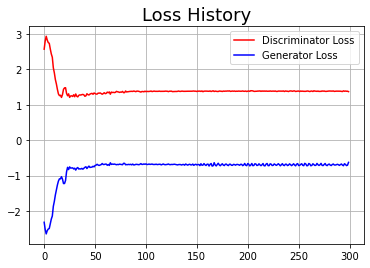

In [14]:
# plot loss
plt.figure(figsize=(6, 4))
plt.plot(loss_D_history, label='Discriminator Loss', color='red')
plt.plot(loss_G_history, label='Generator Loss', color='blue')
plt.title('Loss History', size=18)
plt.legend()
plt.grid()
plt.show()

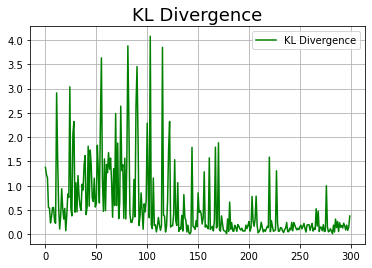

In [15]:
# plot KL divergence
plt.figure(figsize=(6, 4))
plt.plot(KLdivergence_history, label='KL Divergence', color='green')
plt.title('KL Divergence', size=18)
plt.legend()
plt.grid()
plt.show()

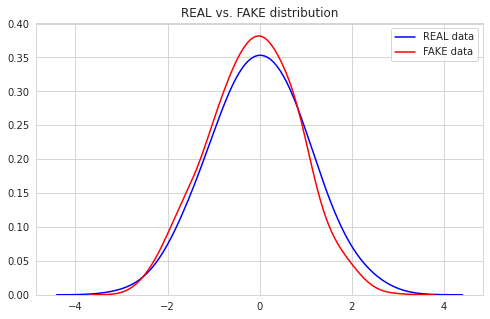

In [16]:
# 학습 완료 후 가짜 데이터 생성하고 그림 그려 보기
z = makeZ(m=real_data.shape[0], n=g_input)
fake_data = Generator(z).numpy() # 학습 완료 후 generator가 그려 낸 분포

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(real_data[:, 0], color='blue', bw=0.5, label='REAL data')
sns.kdeplot(fake_data[:, 0], color='red', bw=0.3, label='FAKE data')
plt.title('REAL vs. FAKE distribution')
plt.legend()
plt.show()

tf.Tensor(
[[0.4773296 ]
 [0.4727556 ]
 [0.46554345]
 [0.48083037]
 [0.5020013 ]
 [0.4765454 ]
 [0.45154893]
 [0.51942885]
 [0.48934934]
 [0.5139421 ]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.4769391 ]
 [0.47082454]
 [0.4811762 ]
 [0.49221426]
 [0.49147302]
 [0.4757505 ]
 [0.47056288]
 [0.47033453]
 [0.5455954 ]
 [0.5300759 ]], shape=(10, 1), dtype=float32)


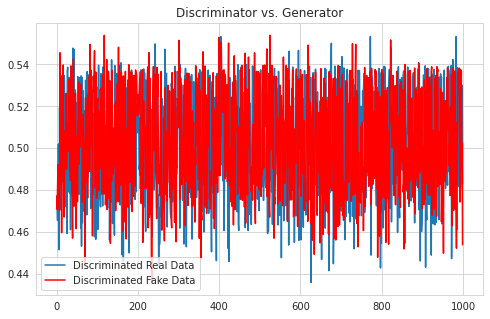

In [18]:
# 학습 완료 후 real data와 fake data 넣어 봤을 때 어떻게 달라지는가?
discriminator_real_values = Discriminator(real_data) # 0.5 근처 값이 많다.
discriminator_fake_values = Discriminator(fake_data) # 0.5 근처 값이 많다.
print(discriminator_real_values[:10])
print(discriminator_fake_values[:10])

plt.figure(figsize=(8, 5))
plt.plot(discriminator_real_values, label='Discriminated Real Data')
plt.plot(discriminator_fake_values, label='Discriminated Fake Data', color='red')
plt.title("Discriminator vs. Generator")
plt.legend()
plt.show()

# 참고: 똑같은 데 제대로 못 학습했을 경우
- 처음에 Adam Optimizer 학습률 0.05로 했더니 학습 제대로 안 되었다.
- loss 난리남.
- 그래프도 제대로 안 그려짐.

학습 횟수 설정: 3000
Epoch 0 : loss-D 1.3386, loss-G -0.0004, KL-Divergence 0.1134
Epoch 10 : loss-D 10.1483, loss-G -10.1245, KL-Divergence 0.4185
Epoch 20 : loss-D 0.0355, loss-G -0.0004, KL-Divergence 0.1131
Epoch 30 : loss-D 0.0143, loss-G -0.0083, KL-Divergence 0.0810
Epoch 40 : loss-D 0.0039, loss-G -0.0000, KL-Divergence 0.1084
Epoch 50 : loss-D 0.0160, loss-G -0.0099, KL-Divergence 0.1567
Epoch 60 : loss-D 0.1363, loss-G -0.0686, KL-Divergence 0.0914
Epoch 70 : loss-D 0.2456, loss-G -0.1994, KL-Divergence 0.1196
Epoch 80 : loss-D 0.1573, loss-G -0.0985, KL-Divergence 0.0669
Epoch 90 : loss-D 0.2456, loss-G -0.2029, KL-Divergence 0.1322
Epoch 100 : loss-D 0.1703, loss-G -0.1356, KL-Divergence 0.0433
Epoch 110 : loss-D 0.2370, loss-G -0.2041, KL-Divergence 0.7247
Epoch 120 : loss-D 0.1839, loss-G -0.1236, KL-Divergence 0.3409
Epoch 130 : loss-D 0.1941, loss-G -0.1434, KL-Divergence 0.0627
Epoch 140 : loss-D 0.2723, loss-G -0.1848, KL-Divergence 0.0586
Epoch 150 : loss-D 0.2165, loss-G 

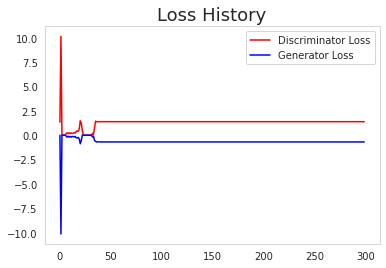

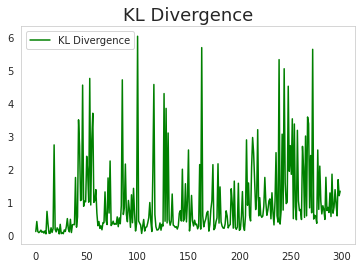

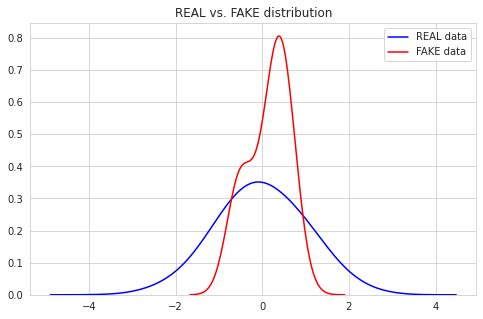

tf.Tensor(
[[0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]
 [0.4999789]], shape=(10, 1), dtype=float32)


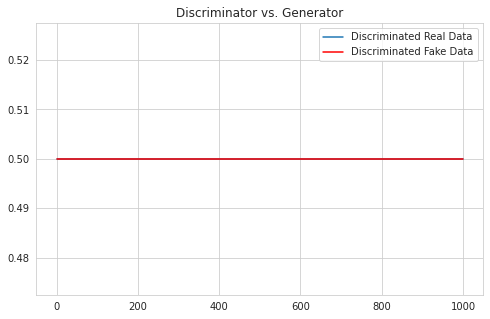

In [20]:
# module import
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# 실제 데이터(가우지안 분포) 생성
real_data = np.random.normal(size=1000).astype(np.float32)
real_data = real_data.reshape(real_data.shape[0], 1) # (1000, 1)
real_data.shape

# 미니배치용 데이터 셋
real_data_batch = tf.data.Dataset.from_tensor_slices(real_data)\
                    .shuffle(buffer_size=real_data.shape[0])\
                    .batch(batch_size=300)
real_data_batch

# KL Divergence 계산 함수 정의
def calc_KL(P, Q):
    hist_P, bins_P = np.histogram(P)
    hist_Q, bins_Q = np.histogram(Q)

    pdf_P = hist_P / (np.sum(hist_P) + 1e-8)
    pdf_Q = hist_Q / (np.sum(hist_Q) + 1e-8)

    kld_PQ = np.sum(pdf_P * (np.log(pdf_P + 1e-8) - np.log(pdf_Q + 1e-8)))

    return pdf_P, pdf_Q, kld_PQ

# log 클리핑
def clip_log(x):
    return tf.math.log(x + 1e-8)

# Discriminator 네트워크
d_input = real_data.shape[1]
d_hidden = 8
d_output = 1 # 주의

d_Wh = tf.Variable(tf.random.normal(shape=[d_input, d_hidden]), name='D_hidden_weight')
d_Bh = tf.Variable(tf.random.normal(shape=[d_hidden]), name='D_hidden_bias')
d_Wo = tf.Variable(tf.random.normal(shape=[d_hidden, d_output]), name='D_output_weight')
d_Bo = tf.Variable(tf.random.normal(shape=[d_output]), name='D_output_bias')

theta_D = [d_Wh, d_Bh, d_Wo, d_Bo] # 파라미터 한 번에 묶기

# Generator 네트워크
g_input = 8
g_hidden = 4
g_output = d_input # 주의

g_Wh = tf.Variable(tf.random.normal(shape=[g_input, g_hidden]), name='G_hidden_weight')
g_Bh = tf.Variable(tf.random.normal(shape=[g_hidden]), name='G_hidden_bias')
g_Wo = tf.Variable(tf.random.normal(shape=[g_hidden, g_output]), name='G_output_weight')
g_Bo = tf.Variable(tf.random.normal(shape=[g_output]), name='G_output_bias')

theta_G = [g_Wh, g_Bh, g_Wo, g_Bo] # 파라미터 한 번에 묶기

# Discriminator: 들어온 데이터가 맞는지 아닌지 출력
def Discriminator(data):
    d_Hidden = tf.matmul(data, d_Wh) + d_Bh
    d_Hidden = tf.nn.relu(d_Hidden) # activation
    d_Out = tf.matmul(d_Hidden, d_Wo) + d_Bo 
    d_Out = tf.nn.sigmoid(d_Out)
    return d_Out

# Generator: 들어온 데이터 넣어 줌.
def Generator(data):
    g_Hidden = tf.matmul(data, g_Wh) + g_Bh
    g_Hidden = tf.nn.relu(g_Hidden)
    g_Out = tf.matmul(g_Hidden, g_Wo) + g_Bo
    return g_Out # activation 없음.

# 가짜 데이터 생성: (m, n) 크기의 랜덤한 정규분포 = 원래 real과 같다는 보장 없음.
def makeZ(m, n=g_input):
    z = np.random.normal(-1.0, 1.0, size=[m, n]).astype(np.float32)
    return z

# Discriminator Loss
def loss_Discriminator(x, z):
    Dx = Discriminator(x) # discriminator가 판별한 진짜 x
    Gz = Generator(z) # generator가 생성한 가짜 데이터
    DGz = Discriminator(Gz) # discriminator가 판별한 가짜 데이터 z

    loss = tf.reduce_mean(clip_log(Dx) + clip_log(1-DGz))
    
    return -loss # minimize로 바꿔 줌.

# Generator Loss
def loss_Generator(z):
    Gz = Generator(z)
    DGz = Discriminator(Gz)

    loss = tf.reduce_mean(clip_log(1-DGz))
    return loss

# 옵티마이저: 0.005로 했을 때 난리났다.
opt = Adam(learning_rate=0.05)

# 학습 시 loss, KLD 기록
loss_D_history = []
loss_G_history = []
KLdivergence_history=[]

# 학습 파라미터
EPOCHS = int(input('학습 횟수 설정: '))

for epoch in range(EPOCHS): # 1번 학습할 때마다

    for X_batch in real_data_batch: # 미니배치 단위로 밀어 넣음.
        Z_batch = makeZ(m=X_batch.shape[0], n=g_input) # 가짜 데이터

        opt.minimize(lambda: loss_Discriminator(X_batch, Z_batch), var_list=theta_D) # discriminator먼저 학습한 뒤,
        opt.minimize(lambda: loss_Generator(Z_batch), var_list=theta_G) # generator 학습.

    if epoch % 10 == 0: # 10회 학습 주기별로 기록
        loss_D_history.append(loss_Discriminator(X_batch, Z_batch))
        loss_G_history.append(loss_Generator(Z_batch))
        P, Q, kld = calc_KL(X_batch, Generator(Z_batch)) # 원래 X와 generator가 만들어 낸 Z의 분포 차이 계산
        KLdivergence_history.append(kld)

        print("Epoch %d : loss-D %.4f, loss-G %.4f, KL-Divergence %.4f" %(epoch, loss_D_history[-1], loss_G_history[-1], KLdivergence_history[-1]))

# plot loss
plt.figure(figsize=(6, 4))
plt.plot(loss_D_history, label='Discriminator Loss', color='red')
plt.plot(loss_G_history, label='Generator Loss', color='blue')
plt.title('Loss History', size=18)
plt.legend()
plt.grid()
plt.show()

# plot KL divergence
plt.figure(figsize=(6, 4))
plt.plot(KLdivergence_history, label='KL Divergence', color='green')
plt.title('KL Divergence', size=18)
plt.legend()
plt.grid()
plt.show()

# 학습 완료 후 가짜 데이터 생성하고 그림 그려 보기
z = makeZ(m=real_data.shape[0], n=g_input)
fake_data = Generator(z).numpy() # 학습 완료 후 generator가 그려 낸 분포

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(real_data[:, 0], color='blue', bw=0.5, label='REAL data')
sns.kdeplot(fake_data[:, 0], color='red', bw=0.3, label='FAKE data')
plt.title('REAL vs. FAKE distribution')
plt.legend()
plt.show()

# 학습 완료 후 real data와 fake data 넣어 봤을 때 어떻게 달라지는가?
discriminator_real_values = Discriminator(real_data) # 0.5 근처 값이 많다.
discriminator_fake_values = Discriminator(fake_data) # 0.5 근처 값이 많다.
print(discriminator_real_values[:10])
print(discriminator_fake_values[:10])

plt.figure(figsize=(8, 5))
plt.plot(discriminator_real_values, label='Discriminated Real Data')
plt.plot(discriminator_fake_values, label='Discriminated Fake Data', color='red')
plt.title("Discriminator vs. Generator")
plt.legend()
plt.show()

